# 基于图卷积 QSAR 模型计算原子对分子的贡献

在前面的教程中，我们介绍了模型可解释性的概念：了解模型为什么会产生它所产生的结果。在本教程中，我们将学习原子对分子的贡献，这是解释作用与分子的模型的有用工具。

想法很简单：从分子中删除一个原子，看看模型的预测如何变化。一个原子的“原子贡献”被定义为整个分子和去除此原子后剩下的碎片之间的活性差。这是一种衡量原子对预测结果影响程度的方法。

贡献在文献中也称为“属性”、“着色”（"attributions", "coloration"）等。这是一种模型解释方法[1]，类似于 QSAR 域中的 Similarity maps[2]，或其他领域(图像分类等)中的遮挡方法（occlusion methods）。目前的实现在[4]中使用。

Mariia Matveieva, Pavel Polishchuk. Institute of Molecular and Translational Medicine, Palacky University, Olomouc, Czech Republic.

<img src="https://github.com/deepchem/deepchem/blob/master/examples/tutorials/assets/atomic_contributions_tutorial_data/index.png?raw=1">

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Atomic_Contributions_for_Molecules.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following installation commands. This will take about 5 minutes to run to completion and install your environment. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install Anaconda on your local machine.

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  24692      0 --:--:-- --:--:-- --:--:-- 24692


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing openmm, pdbfixer
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 608 kB 34.8 MB/s 
     |████████████████████████████████| 20.6 MB 1.3 MB/s 


'2.6.0.dev'

## 血脑屏障通透性的 QSAR 分类模型

血脑屏障的通透性是化合物进入中枢神经系统的能力。在这里，我们使用了一个相对较小的化合物数据集，这些化合物是在没有任何载体的情况下通过扩散运输的。属性定义为log10(大脑浓度/血液浓度)。值为正值(和0)的化合物被标记为活性化合物，其他化合物被标记为非活性化合物。在建模之后，我们将确定有利于扩散和不利于扩散的原子。

首先让我们创建数据集。分子存储在一个 SDF 文件中。

In [8]:
import os
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/logBB.sdf',
    current_dir,
    'logBB.sdf'
)
DATASET_FILE =os.path.join(current_dir, 'logBB.sdf')
# Create RDKit mol objects, since we will need them later.
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["logBB_class"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)


现在，让我们构建和训练一个GraphConvModel。

In [10]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [11]:
m = dc.models.GraphConvModel(1, mode="classification", batch_normalize=False, batch_size=100)
m.fit(dataset, nb_epoch=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(331,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(331, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(1646,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16

0.5348201115926107

让我们加载一个测试集，看看效果如何。

In [12]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/logBB_test_.sdf',
    current_dir,
    'logBB_test_.sdf'
)
TEST_DATASET_FILE = os.path.join(current_dir, 'logBB_test_.sdf')
loader = dc.data.SDFLoader(tasks=["p_np"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred =  m.predict(test_dataset)
pred = np.argmax(np.squeeze(pred),axis=1)
ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)
print(ba)

0.7444444444444445


平衡精度足够高。现在让我们继续进行模型解释并估计单个原子对预测的贡献。

## 片段数据集

现在让我们基于训练集准备一个片段数据集。(也可以使用其他感兴趣的未见过的数据集)。这些片段将被用来评估单个原子的贡献。

对于每个分子，我们将生成一个 ConvMol 对象列表。指定 `per_atom_fragmentation=True` 告诉它遍历所有的重原子，并特征化当前重原子被删除的分子。也就是说如果某个分子有n个重原子，经过下面过程后，会有n个片段数据，每个片段数据是这个分子中删除了某个原子之后的片段，每个片段数据各不相同。

In [ ]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:885: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(features), valid_inds


该数据集仍然具有与原始训练集相同数量的样本，但每个样本现在表示为一个ConvMol对象（每个片段一个）列表，而不是单个ConvMol。

重要提示：片段的顺序取决于输入格式。如果是SDF，则片段顺序与相应 mol 块中的原子顺序相同。如果是SMILES（比如 csv，其中分子用 SMILES 表示），则顺序由 RDKit CanonicalRankAtoms 给出。

In [14]:
print(frag_dataset.X.shape)

(298,)


我们真的想把每个片段当作一个单独的样本。我们可以使用 FlatteningTransformer 来扁平化片段列表。

In [15]:
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(5111,)


## 预测原子对活性的贡献

现在我们将预测分子及其片段的活性。然后，对于每个片段，我们将发现活性差异：移除一个原子时活性的变化。

注意：这里，在分类背景下，我们使用模型的概率输出作为活性。所以贡献是概率差，也就是。一个给定的原子增加/减少分子活性的概率。

In [16]:
# whole  molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

We take the difference to find the atomic contributions.

In [17]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [18]:
df

Fragment  Molecule   Contrib
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.756537  0.811550  0.055013
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.752759  0.811550  0.058791
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.747012  0.811550  0.064538
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.815878  0.811550 -0.004328
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C  0.741805  0.811550  0.069745
...                                              ...       ...       ...
c1cncc(C2CCCN2)c1                           0.780473  0.813031  0.032559
c1cncc(C2CCCN2)c1                           0.722649  0.813031  0.090383
c1cncc(C2CCCN2)c1                           0.721607  0.813031  0.091425
c1cncc(C2CCCN2)c1                           0.683299  0.813031  0.129732
c1cncc(C2CCCN2)c1                           0.674451  0.813031  0.138581

[5111 rows x 3 columns]

我们可以使用 RDKit 的 SimilarityMaps 功能将结果可视化。每个原子都根据它对活性的影响而着色。

In [19]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps    

让我们看一些图片：

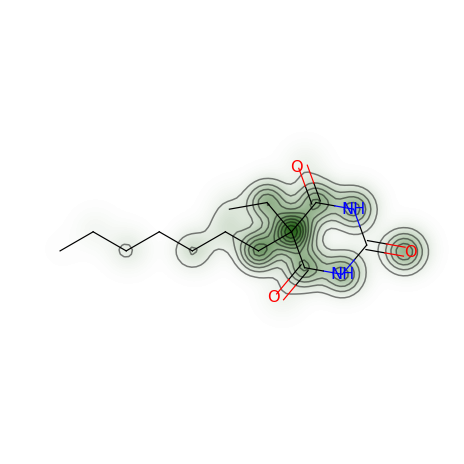

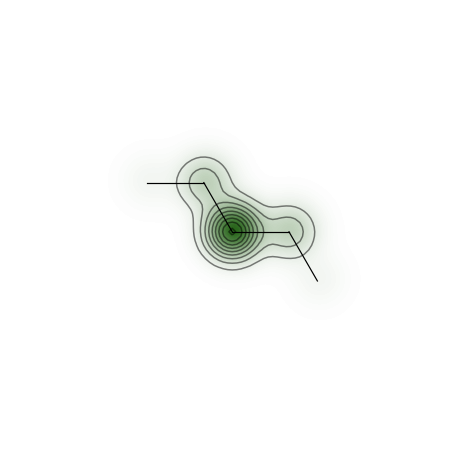

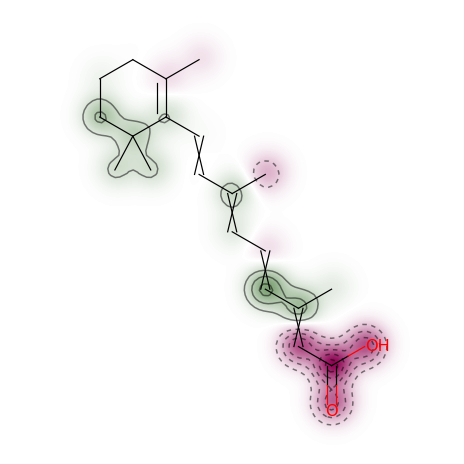

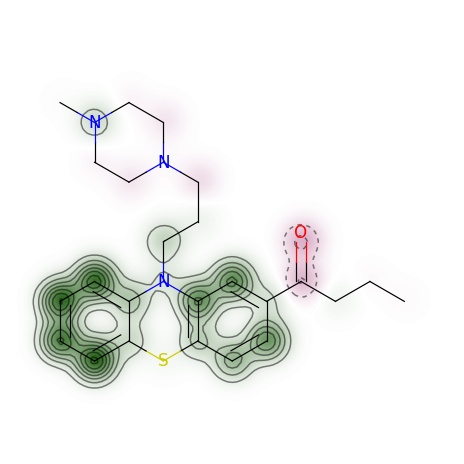

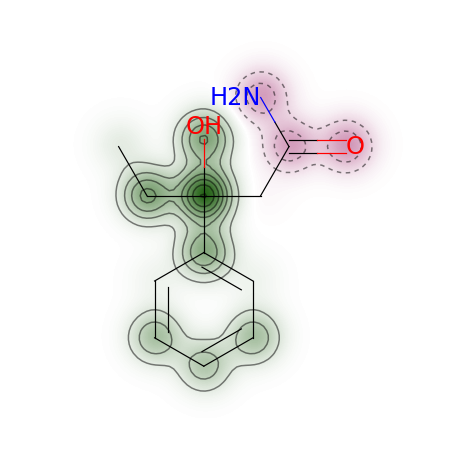

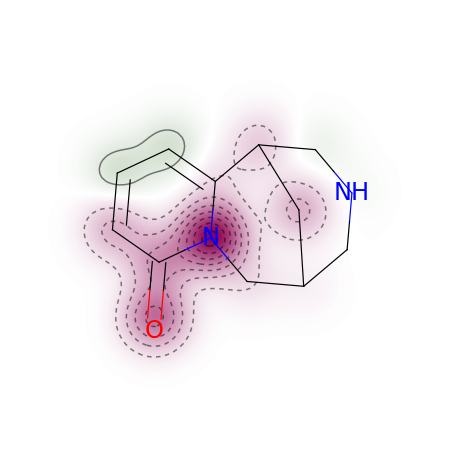

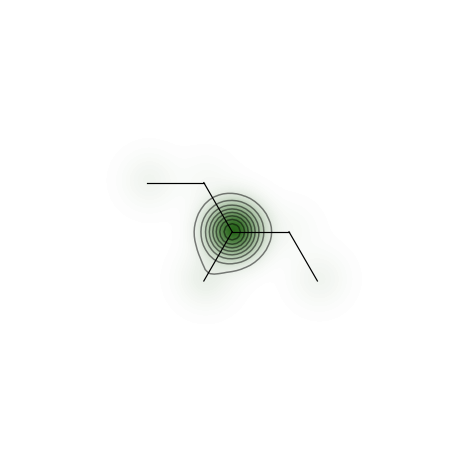

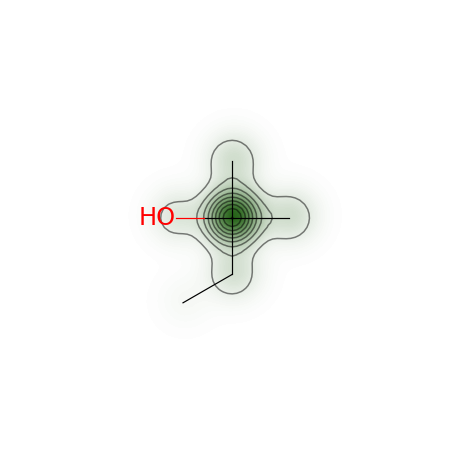

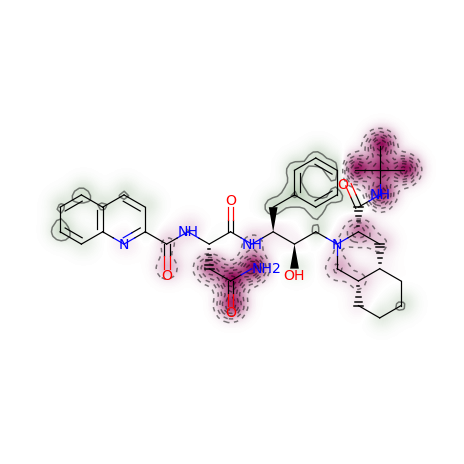

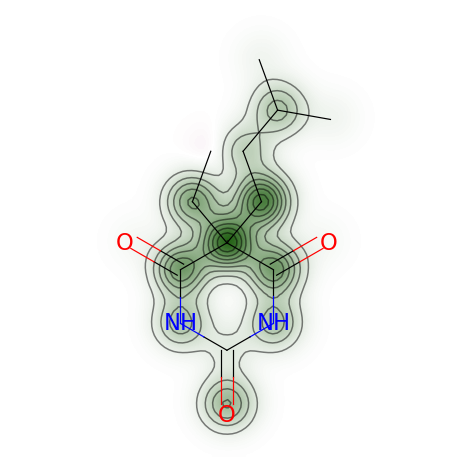

In [20]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

我们可以看到，芳香族或脂肪族化合物对血脑屏障通透性有积极影响，而极性或带电杂原子对血脑屏障通透性有消极影响。这与文献资料基本一致。

## 回归的任务

上面的例子使用了一个分类模型。同样的技术也可以用于回归模型。让我们看一个回归任务，水生毒性(对水生生物梨形虫)。

毒性定义为 log10(IGC50)（抑制菌落生长50%的浓度）。梨形螺旋杆菌的毒性团将通过原子贡献来鉴定。

以上所有步骤都是相同的：加载数据，特征化，构建模型，创建片段数据集，计算贡献，并将它们可视化。

注意：这一次由于是回归，贡献将以活性单位，而不是概率。

In [21]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Work_set_OCHEM.sdf',
    current_dir,
    'Tetrahymena_pyriformis_Work_set_OCHEM.sdf'
)
DATASET_FILE =os.path.join(current_dir, 'Tetrahymena_pyriformis_Work_set_OCHEM.sdf')

# create RDKit mol objects, we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["IGC50"], 
                           featurizer=dc.feat.ConvMolFeaturizer(), sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

Create and train the model.

In [22]:
np.random.seed(2020)
tf.random.set_seed(2020)
m = dc.models.GraphConvModel(1, mode="regression", batch_normalize=False)
m.fit(dataset, nb_epoch=40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_14:0", shape=(291,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_13:0", shape=(291, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_17:0", shape=(910,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/R

0.12407124519348145

加载测试数据集并检验模型的性能。

In [23]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Test_set_OCHEM.sdf',
    current_dir,
    'Tetrahymena_pyriformis_Test_set_OCHEM.sdf'
)




TEST_DATASET_FILE = os.path.join(current_dir, 'Tetrahymena_pyriformis_Test_set_OCHEM.sdf')
loader = dc.data.SDFLoader(tasks=["IGC50"], sanitize= True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred = m.predict(test_dataset)
mse = metrics.mean_squared_error(y_true=test_dataset.y, y_pred=pred)
r2 = metrics.r2_score(y_true=test_dataset.y, y_pred=pred)
print(mse)
print(r2)

0.2381780323921622
0.784334539071699


再次加载训练集，但这次设置为 `per_atom_fragmentation=True`。

In [24]:
loader = dc.data.SDFLoader(tasks=[], # dont need any task
                           sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True)) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)
tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:885: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(features), valid_inds


计算活性差异。

In [25]:
# whole molecules
pred = m.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convenience

# fragments
pred_frags = m.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convenience

# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

让我们取一些活性中等（不是非常活跃/不活跃）的分子，并可视化其原子贡献。

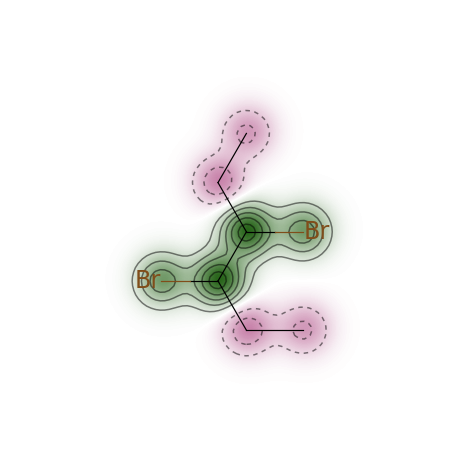

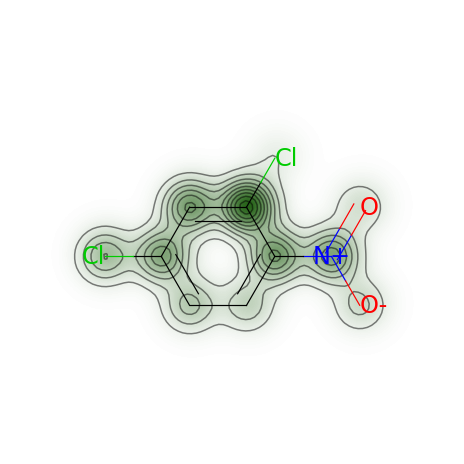

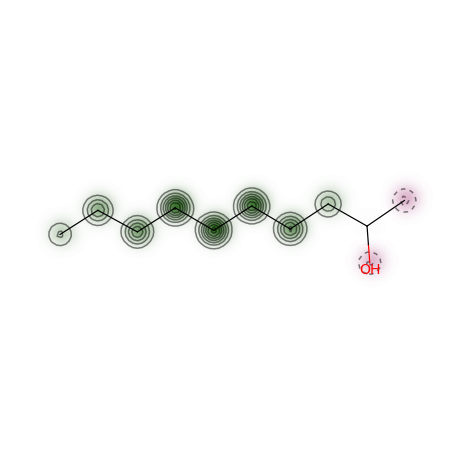

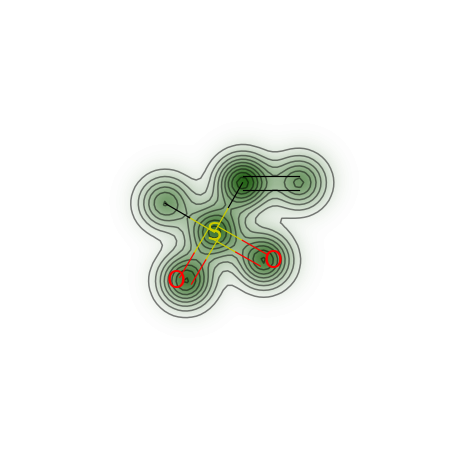

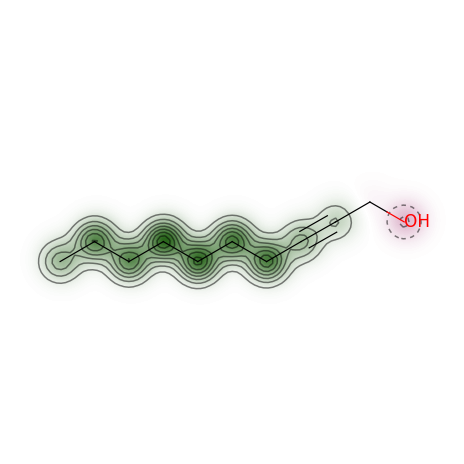

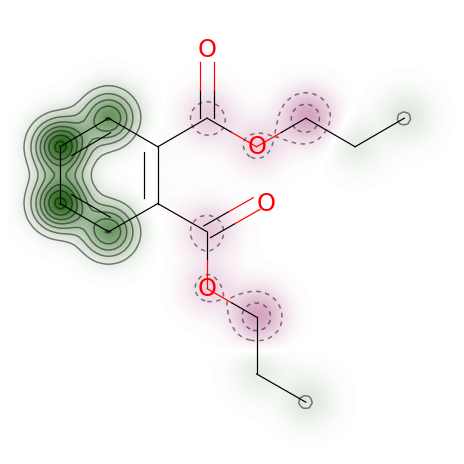

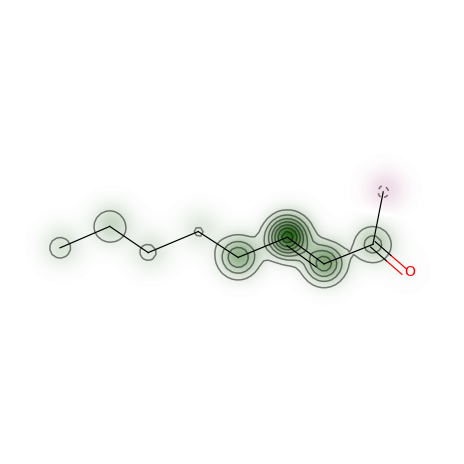

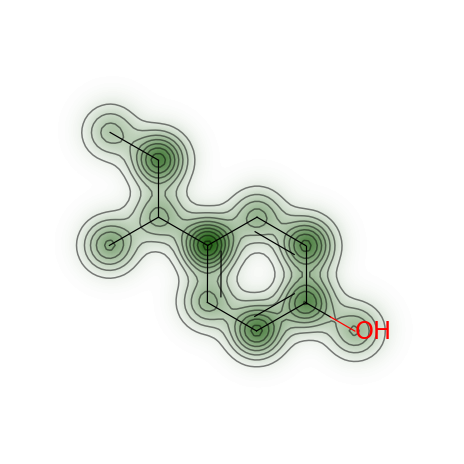

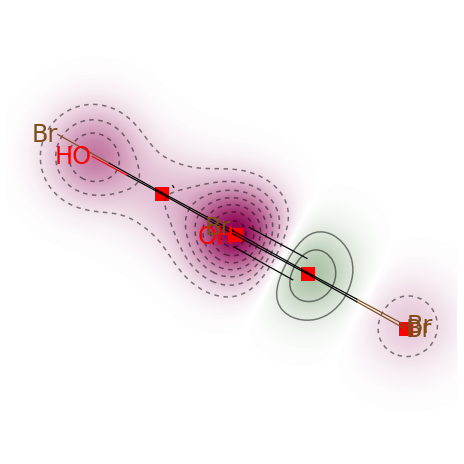

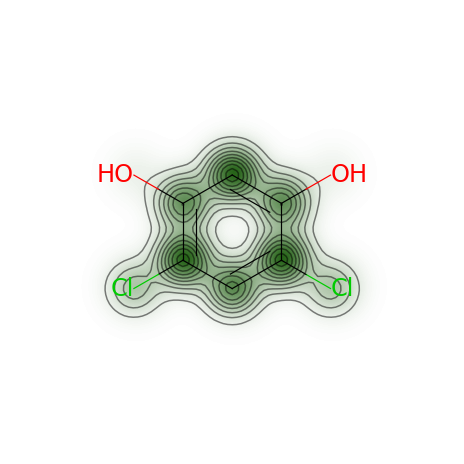

In [26]:
maps = vis_contribs([mol for mol in mols if float(mol.GetProp("IGC50"))>3 and float(mol.GetProp("IGC50"))<4][:10], df)

我们可以看到，已知的毒株为绿色，分别为硝基芳烃类、卤代芳烃类、长烷基链类和醛类：而羧基、醇和氨基则具有解毒作用，与文献[3]一致。

# 附录

在本教程中，我们操作的是 SDF 文件。然而，如果我们使用 SMILES 作为输入的 CSV 文件，则 dataframe 中原子的顺序与原始原子的顺序不对应。如果我们想要恢复每个分子的原始原子顺序（为了添加到我们的 dataframe 中），我们需要使用 RDKit 的 Chem.rdmolfiles.CanonicalRankAtoms。这里有一些实用程序可以做到这一点。

我们可以添加一个包含原子 id 的列（就像输入分子那样），并将得到的 dataframe 用于“python-rdkit-deepchem”环境之外的任何其他软件的分析。

In [27]:
def get_mapping(mols, mol_names): 
    """perform mapping:
    atom number original <-> atom number(position) 
    after ranking (both 1-based)"""
    # mols - RDKit mols
    # names  - any seq of strings
    # return list of nested lists: [[molecule, [atom , atom, ..], [...]]
    assert(len(mols)==len(mol_names))
    mapping = []
    for m,n in zip(mols, mol_names):
        atom_ids = [i+1 for i in list(Chem.rdmolfiles.CanonicalRankAtoms(m))]
        mapping.append([n, atom_ids])
    return mapping

In [28]:
def append_atomid_col(df, mapping):
    # add column with CORRECT atom number(position)
    for i in mapping:
        df.loc[i[0],"AtomID"] = i[1]
    return df   

# 参考文献：

1. Polishchuk, P., O. Tinkov, T. Khristova, L. Ognichenko, A. Kosinskaya, A. Varnek & V. Kuz’min (2016) Structural and Physico-Chemical Interpretation (SPCI) of QSAR Models and Its Comparison with Matched Molecular Pair Analysis. Journal of Chemical Information and Modeling, 56, 1455-1469.

2. Riniker, S. & G. Landrum (2013) Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods. Journal of Cheminformatics, 5, 43.

3. M. Matveieva, M. T. D. Cronin, P. Polishchuk, Mol. Inf. 2019, 38, 1800084. 

4. Matveieva, M., Polishchuk, P. Benchmarks for interpretation of QSAR models. J Cheminform 13, 41 (2021). https://doi.org/10.1186/s13321-021-00519-x


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!